In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

In [5]:
cars = pd.read_csv('https://raw.githubusercontent.com/andrew-ryabchenko/data/main/car_data(non_dealer_entries).csv',
                   index_col='Unnamed: 0')

In [7]:
cars.dropna(subset=['model'], inplace=True)

# Wrangle Data I
> ### Search for outliers and extreme values

In [8]:
# Look at dtypes 
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196337 entries, 0 to 199845
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         196337 non-null  int64  
 1   year          195711 non-null  float64
 2   manufacturer  183586 non-null  object 
 3   model         196337 non-null  object 
 4   condition     127200 non-null  object 
 5   cylinders     128131 non-null  object 
 6   fuel          194854 non-null  object 
 7   odometer      151015 non-null  float64
 8   title_status  195470 non-null  object 
 9   transmission  195569 non-null  object 
 10  drive         135633 non-null  object 
 11  size          77197 non-null   object 
 12  type          133211 non-null  object 
 13  paint_color   134589 non-null  object 
 14  state         196337 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 15.0+ MB


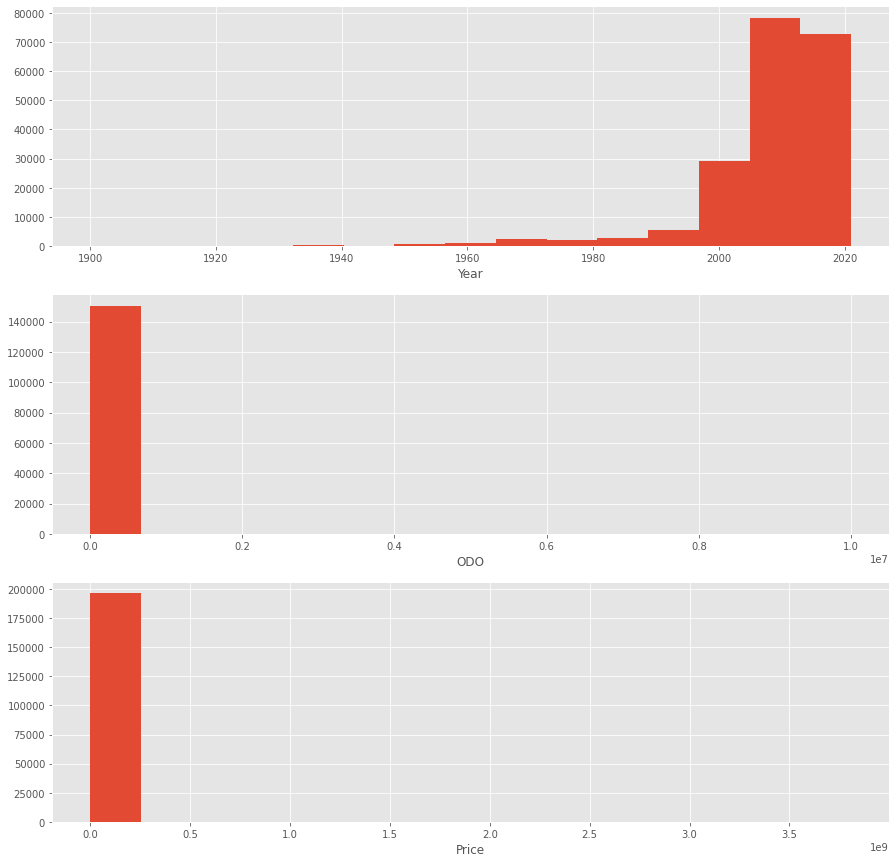

In [9]:
#Visualize data to find extreme values and outliers
plt.style.use('ggplot')
fig, (ax,ax1,ax2) = plt.subplots(nrows=3)

ax.hist(cars['year'], bins=15)
ax.set_xlabel('Year')
ax1.hist(cars['odometer'], bins=15)
ax1.set_xlabel('ODO')
ax2.hist(cars['price'], bins=15)
ax2.set_xlabel('Price')
fig.set_size_inches([15,15])
plt.show();

In [10]:
# Filter vehicles of year 1990+
cars = cars[cars['year']>1990][cars['year']<=2019]
# Filter odometer values less than 300000
cars = cars[cars['odometer']<200000]
# Filter price values less than 200000
cars = cars[cars['price']<100000][cars['price']>1000]

<ipython-input-10-99b96d3caf4b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars = cars[cars['year']>1990][cars['year']<=2019]
<ipython-input-10-99b96d3caf4b>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars = cars[cars['price']<100000][cars['price']>1000]


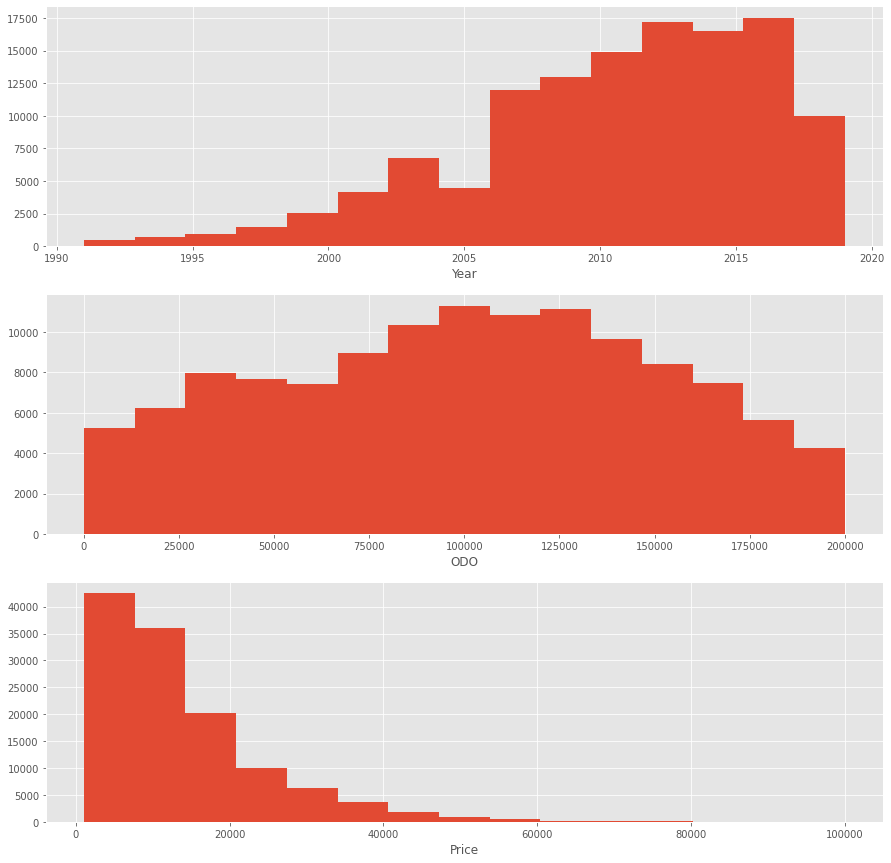

In [11]:
#Visualize data to find extreme values and outliers
plt.style.use('ggplot')
fig, (ax,ax1,ax2) = plt.subplots(nrows=3)

ax.hist(cars['year'], bins=15)
ax.set_xlabel('Year')
ax1.hist(cars['odometer'], bins=15)
ax1.set_xlabel('ODO')
ax2.hist(cars['price'], bins=15)
ax2.set_xlabel('Price')
fig.set_size_inches([15,15])
plt.show();

In [9]:
# Distributions look much better now!

# Wrangle Data II
> ### Clean the data

In [12]:
# Filter down to clean and lien title entries 
cars['title_status'].value_counts()
cars = cars[~(cars['title_status']=='missing')][~(cars['title_status']=='parts only')]\
[~(cars['title_status']=='salvage')][~(cars['title_status']=='rebuilt')]

# Drop entries with missing title

cars.dropna(subset=['title_status'], inplace=True)

<ipython-input-12-fa02be0aaf7c>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars = cars[~(cars['title_status']=='missing')][~(cars['title_status']=='parts only')]\


In [13]:
# Check for what types of cars are presents in dataset

cars['type'].value_counts()

sedan          26005
SUV            24090
truck           9063
pickup          7315
coupe           4411
hatchback       4027
wagon           3481
van             3120
other           2768
mini-van        2725
convertible     2528
offroad          212
bus              200
Name: type, dtype: int64

In [14]:
# First step is to filter cars to the only types we need. Model will only make price predictions 
# for passenger cars and trucks. So we need to exclude van, other, offroad, and bus types of vehicles. 

cars = cars[~(cars['type']=='bus')][~(cars['type']=='offroad')][~(cars['type']=='van')][~(cars['type']=='other')]

<ipython-input-14-bf770df86244>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cars = cars[~(cars['type']=='bus')][~(cars['type']=='offroad')][~(cars['type']=='van')][~(cars['type']=='other')]


In [15]:
# Check what brands are avaliable in dataset

cars['manufacturer'].value_counts()

ford               19164
chevrolet          14618
toyota              8577
honda               6508
nissan              6316
jeep                4759
dodge               3874
gmc                 3668
subaru              3441
bmw                 3179
hyundai             3154
ram                 2897
volkswagen          2789
mercedes-benz       2426
kia                 2360
chrysler            2059
cadillac            1676
buick               1614
mazda               1613
lexus               1498
audi                1298
lincoln             1018
acura                969
pontiac              891
volvo                869
infiniti             773
mitsubishi           689
mini                 598
mercury              562
saturn               522
rover                425
jaguar               335
fiat                 229
tesla                115
alfa-romeo            36
harley-davidson       25
ferrari               13
aston-martin          12
land rover             7
porche                 2


In [16]:
# Filter data to only brands with 1000+ entries, so there are sufficient amount of data for each 
# brand to build accurate predictions

# Identify brands to keep 
brand_freqs = cars['manufacturer'].value_counts()
brand_names = cars['manufacturer'].value_counts().index
brands_to_keep = [brand for brand in brand_names if brand_freqs[brand] > 1000]

# Create boolean mask 
mask = pd.Series(cars['manufacturer']).apply(lambda x: True if x in brands_to_keep else False)

# Apply boolean mask
cars = cars[mask]

# Check results
cars['manufacturer'].value_counts()


ford             19164
chevrolet        14618
toyota            8577
honda             6508
nissan            6316
jeep              4759
dodge             3874
gmc               3668
subaru            3441
bmw               3179
hyundai           3154
ram               2897
volkswagen        2789
mercedes-benz     2426
kia               2360
chrysler          2059
cadillac          1676
buick             1614
mazda             1613
lexus             1498
audi              1298
lincoln           1018
Name: manufacturer, dtype: int64

In [17]:
# Loading json file with all brands and corrensponding models of the vehicles

file = open('brands_n_models.json','r')
contains = file.read()
file.close()
models = json.loads(contains)

In [18]:
import re
# Create function to clean and restore messy entries for car models

def model_restore(data,models):
    data = data.copy()
    data['manufacturer'] = data['manufacturer'].str.lower()
    data['model'] = data['model'].str.lower().apply(lambda x: x.replace(' ',''))
    labels = []
    for i in data.index:
        current_brand = models[data.loc[i]['manufacturer']]
        current_model = data.loc[i]['model']
        for ind in range(len(current_brand)):
            occurence = re.search(current_brand[ind], current_model)
            if (occurence):
                data.at[i, 'model'] = occurence.group()
                break
            
            # Add entries that we could not recover to the drop list
            if (ind==(len(current_brand)-1)):
                labels.append(i)
    
    # Drop entries according to the drop list
    data.drop(labels=labels, axis=0,inplace=True)
         
    return data    

In [19]:
cars_c = model_restore(cars,models)

In [20]:
# Drop entries for models that are present less than 100 times
count = cars_c['model'].value_counts(ascending=True)
aval_models = cars_c['model'].value_counts(ascending=True).index
models_to_drop = [model for model in aval_models if count[model]<100]
labels = []
for i in cars_c.index:
    model = cars_c.loc[i]['model']
    if (model in models_to_drop):
        labels.append(i)
cars_c.drop(labels=labels, axis=0, inplace=True)        


In [21]:
cars_c['model'].value_counts(ascending=True)

canyon        100
a3            100
q7            100
xts           101
x1            103
             ... 
civic        1662
camry        1685
accord       1690
escape       1863
silverado    3819
Name: model, Length: 164, dtype: int64

In [22]:
# Restore missing 'type' column entries using dictionary that maps model and type of vehicle.
def model_type_mapper(data):
    data = data.copy()
    mapper = {}
    models = list(set(data['model']))
    for model in models:
        # Identifiying mode value for type in corrensponding model
        car_type = data[(data['model']==model)]['type'].mode()[0]
        mapper[model] = car_type
    return mapper

mapper = model_type_mapper(cars_c)

#Sanity check

assert len(mapper.keys()) == cars_c['model'].nunique(), 'Something went wrong...'

# Restore missing types using mapper

for i in cars_c.index:
    
    if (cars_c.at[i,'type'] != cars_c.at[i,'type']):
        
        cars_c.at[i,'type'] = mapper[cars_c.at[i,'model']]
    
    

In [23]:
# Restore missing 'drive' column entries using dictionary that maps type in drive of vehicle.
def type_drive_mapper(data):
    data = data.copy()
    mapper = {}
    types = list(set(data['type'].dropna()))
    for t in types:
        # Identifiying mode value for drive in corrensponding car type
        drive = data[(data['type']==t)]['drive'].mode()[0]
        mapper[t] = drive
    return mapper

drive_mapper = type_drive_mapper(cars_c)

#Sanity check

assert len(drive_mapper.keys()) == cars_c['type'].nunique(), 'Something went wrong...'

# Restore missing drive entries using drive_mapper

for i in cars_c.index:
    if (cars_c.at[i,'drive']!=cars_c.at[i,'drive']):
        cars_c.at[i,'drive'] = drive_mapper[cars_c.at[i,'type']]
   

In [24]:
# Restore missing 'size' column entries using dictionary that maps model and size.
def model_size_mapper(data):
    data = data.copy()
    mapper = {}
    models = list(set(data['model']))
    for model in models:
        # Identifiying mode value for size in corrensponding model
        size = data[(data['model']==model)]['size'].mode()[0]
        mapper[model] = size
    return mapper

size_mapper = model_size_mapper(cars_c)

#Sanity check

assert len(size_mapper.keys()) == cars_c['model'].nunique(), 'Something went wrong...'

# Restore missing size entries using size_mapper

for i in cars_c.index:
    if (cars_c.at[i,'size']!=cars_c.at[i,'size']):
        cars_c.at[i,'size'] = size_mapper[cars_c.at[i,'model']]

In [25]:
# Restore missing 'cylinders' column entries using dictionary that maps model and cylinders.
def model_cylinders_mapper(data):
    data = data.copy()
    mapper = {}
    models = list(set(data['model']))
    for model in models:
        # Identifiying mode value for cylinders in corrensponding model
        cylinders = data[(data['model']==model)]['cylinders'].mode()[0]
        mapper[model] = cylinders
    return mapper

cylinders_mapper = model_cylinders_mapper(cars_c)

#Sanity check

assert len(cylinders_mapper.keys()) == cars_c['model'].nunique(), 'Something went wrong...'

# Restore missing size entries using size_mapper

for i in cars_c.index:
    if ((cars_c.at[i,'cylinders']!=cars_c.at[i,'cylinders']) or (cars_c.at[i,'cylinders']=='other')):
        cars_c.at[i,'cylinders'] = cylinders_mapper[cars_c.at[i,'model']]

In [26]:
# Drop cars with salvage condition
cars_c = cars_c[~(cars_c['condition'] == 'salvage')]

In [27]:
cars_c.isnull().sum()

price               0
year                0
manufacturer        0
model               0
condition       22681
cylinders           0
fuel              563
odometer            0
title_status        0
transmission      153
drive               0
size                0
type                0
paint_color     18347
state               0
dtype: int64

# Data Wrangle III
> ### Make new features

In [28]:
# Make new feature 'age'

cars_c['age'] = 2020 - cars_c['year']
cars_c.drop(columns=['year'], inplace=True)

In [29]:
cars_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78176 entries, 0 to 199845
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         78176 non-null  int64  
 1   manufacturer  78176 non-null  object 
 2   model         78176 non-null  object 
 3   condition     55495 non-null  object 
 4   cylinders     78176 non-null  object 
 5   fuel          77613 non-null  object 
 6   odometer      78176 non-null  float64
 7   title_status  78176 non-null  object 
 8   transmission  78023 non-null  object 
 9   drive         78176 non-null  object 
 10  size          78176 non-null  object 
 11  type          78176 non-null  object 
 12  paint_color   59829 non-null  object 
 13  state         78176 non-null  object 
 14  age           78176 non-null  float64
dtypes: float64(2), int64(1), object(12)
memory usage: 6.0+ MB


In [30]:
# Make new feature 'miles_per_year'. It will be a good indicator if car was extensively used,
# for example served as a livery car, or taxi cab.
# Some values for age and odometer are 0. That will result in NaNs and infs. So will replace them with 0.

cars_c['miles_per_year'] = (cars_c['odometer'] / cars_c['age']).apply(lambda x: 0 if np.isinf(x) else x).apply(lambda x:
                            0 if np.isnan(x) else x).astype(int)


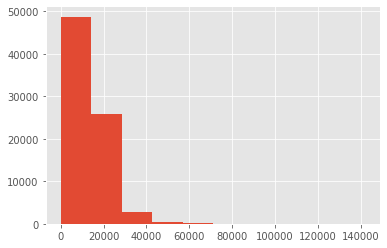

In [31]:
# Lets take a look at the distribution of new feature miles_per_year.
# It's obviously impossible for vehicle to have over 200 000 miles per year use. 
# Such values must be a result of wrong entries for odometer or year. Will need to drop odd entries. 

plt.hist(cars_c['miles_per_year']);

In [32]:
cars_c = cars_c[cars_c['miles_per_year']<75000]

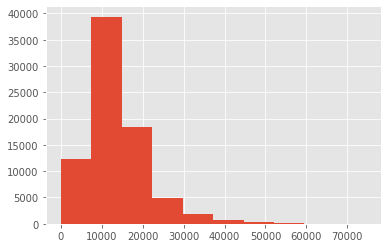

In [33]:
# Now there are much realistic values left to work with. 

plt.hist(cars_c['miles_per_year']);

In [34]:
# Reduce number of condition values. Will merge 'like-new' and 'excellent' in one category - 'excellent'

cars_c['condition'] = cars_c['condition'].apply(lambda x: 'excellent' if (x=='like new') else x)

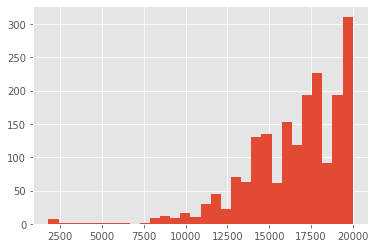

In [35]:
# There is another issue with this dataset. Some car listings come from dealerships that put the price of
# downpayment required for financing instead of full price of the car. Will try to filter those listings out.

ploting_subset = cars_c[(cars_c['age']<4) & (cars_c['odometer'] < 30000) & (cars_c['price'] < 20000)]

# Lets look at the relativaly new cars and their price distribution.
plt.hist(ploting_subset['price'], bins=30);
plt.show()

In [36]:
# # There are some cars that are sold for suspiciously little price while being less than 4 years old. 
# # Everything less is than 5000 price and satisfies (cars_c['age']<4) & (cars_c['odometer'] < 30000) condition
# # falls into abovementioned dealership listings category. Will need to filter it out of the dataset. 

cars_c = cars_c[~((cars_c['age']<3) & (cars_c['odometer'] < 30000) & (cars_c['price'] < 5000))]

## Use RandomForest to predict 'condition' for missing entries 

In [37]:
from sklearn.model_selection import train_test_split

# Create train and test data
train_data = cars_c[cars_c['condition'] == cars_c['condition']]
test_data = cars_c[cars_c['condition'] != cars_c['condition']]

In [38]:
# Create train/val FM and TV
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(columns=['condition']),
                                                 train_data['condition'], test_size=0.33, random_state=42)


In [39]:
# Fit RandomForest model

model_rf = make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OrdinalEncoder(),
            RandomForestClassifier(n_jobs=-1,random_state=42, min_samples_split=2, n_estimators=120, max_depth=70)
            )
model_rf.fit(X_train,y_train);

In [40]:
rf_score = model_rf.score(X_val,y_val)
print(f'RandomForest accuracy: {rf_score}')

RandomForest accuracy: 0.7287922652537281


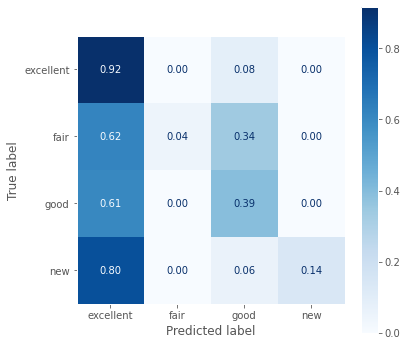

In [41]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots() 

plot_confusion_matrix(model_rf,X_val,y_val,values_format='.2f', normalize='true', cmap=plt.cm.Blues, ax=ax);
ax.grid(visible=False)
fig.set_size_inches([6,6])
plt.show()

> Our model is pretty good at predicting excellent condition, very bad at predicting fair condition, and OK at predicting good condition.

In [42]:
# Restore missing 'condition' values using RandomForest model

missing_values = model_rf.predict(test_data.drop(columns=['condition']))


In [43]:
test_data['condition'] = missing_values

<ipython-input-43-874cc58572cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['condition'] = missing_values


In [44]:
missing_values = test_data[['condition']]

In [45]:
# Impute missing values to the full dataset

for i in missing_values.index:
    cars_c.at[i,'condition'] = missing_values.at[i,'condition']

In [46]:
cars_c.isnull().sum()

price                 0
manufacturer          0
model                 0
condition             0
cylinders             0
fuel                563
odometer              0
title_status          0
transmission        153
drive                 0
size                  0
type                  0
paint_color       18337
state                 0
age                   0
miles_per_year        0
dtype: int64

In [47]:
cars_c.reset_index(drop=True,inplace=True)

In [49]:
cars_c['condition'].value_counts(normalize=True)

excellent    0.732062
good         0.248796
fair         0.017029
new          0.002113
Name: condition, dtype: float64

In [50]:
cars_c.to_csv('./cars_v2(ModelReady).csv')